# Identify Object Positions in Images - YOLO vs VLM

### Utils
Taken from
https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=wizbxA1lm-Tj
https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb#scrollTo=245bc92a470f


In [ ]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))





In [ ]:
!pip install python-dotenv
import openai
import os
from dotenv import load_dotenv
import base64

load_dotenv()
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

image_path = "images/table_scene.jpeg"

def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

base64_image = encode_image(image_path)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                            "You see a table with several objects. Please identify the ceramic mug (cup) on the table. "
                            "It is located to the right of the open book. "
                            "Return the result as a JSON object with the label 'cup' and the bounding box "
                            "in [y1, x1, y2, x2] format using a 1000-scale. Only include the cup."
                            )
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    max_tokens=500
)

gpt_output = response.choices[0].message.content
print(gpt_output)


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
```json
{
  "cup": {
    "bounding_box": [600, 800, 700, 900]
  }
}
```


In [ ]:
parsed = [("cup", [600, 800, 700, 900])]



(1024, 1024)


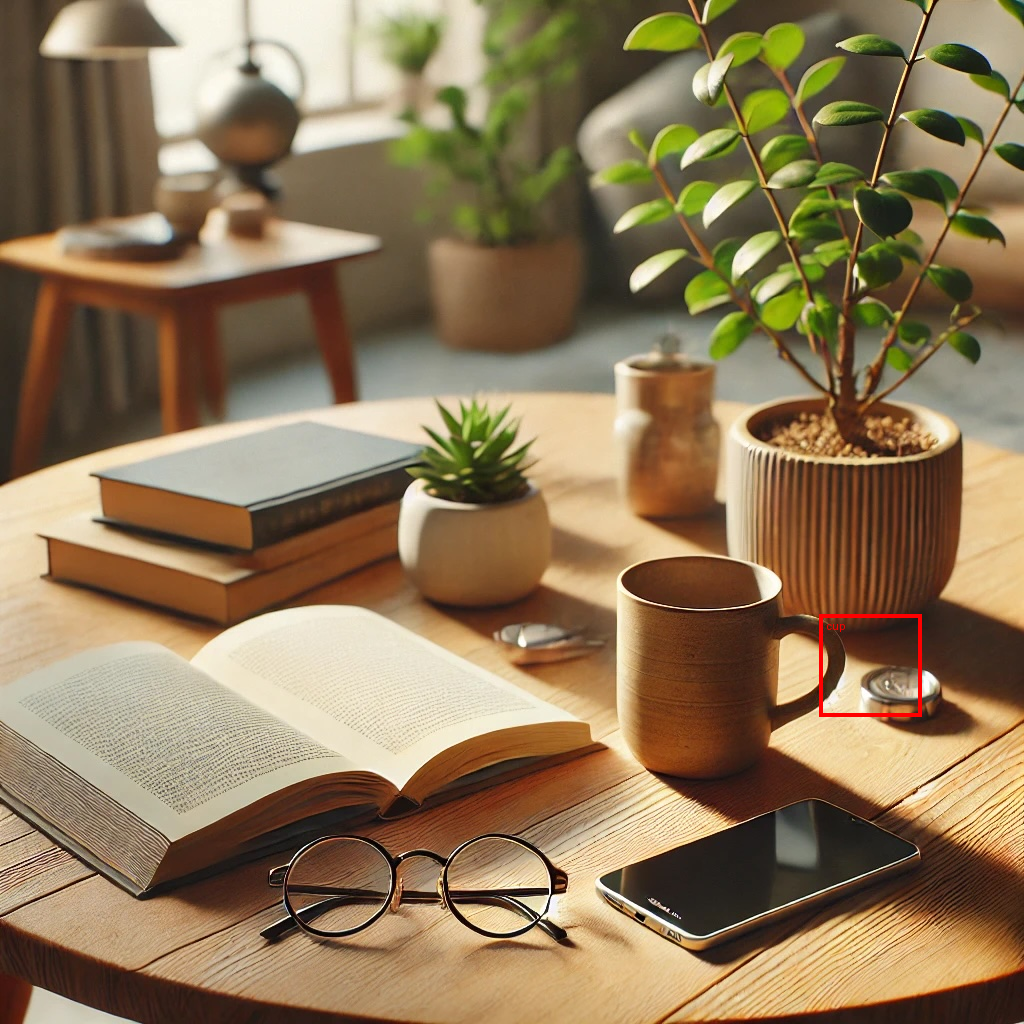

In [ ]:
img = Image.open(image_path)
plot_bounding_boxes(img, parsed)


YOLO --> collab

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 129 kB in 1s (99.9 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Don

100%|██████████| 320k/320k [00:00<00:00, 13.3MB/s]


image 1/1 /content/table_scene.jpeg: 640x640 1 cup, 4 potted plants, 2 dining tables, 1 cell phone, 3 books, 1 vase, 1697.1ms
Speed: 16.8ms preprocess, 1697.1ms inference, 34.5ms postprocess per image at shape (1, 3, 640, 640)


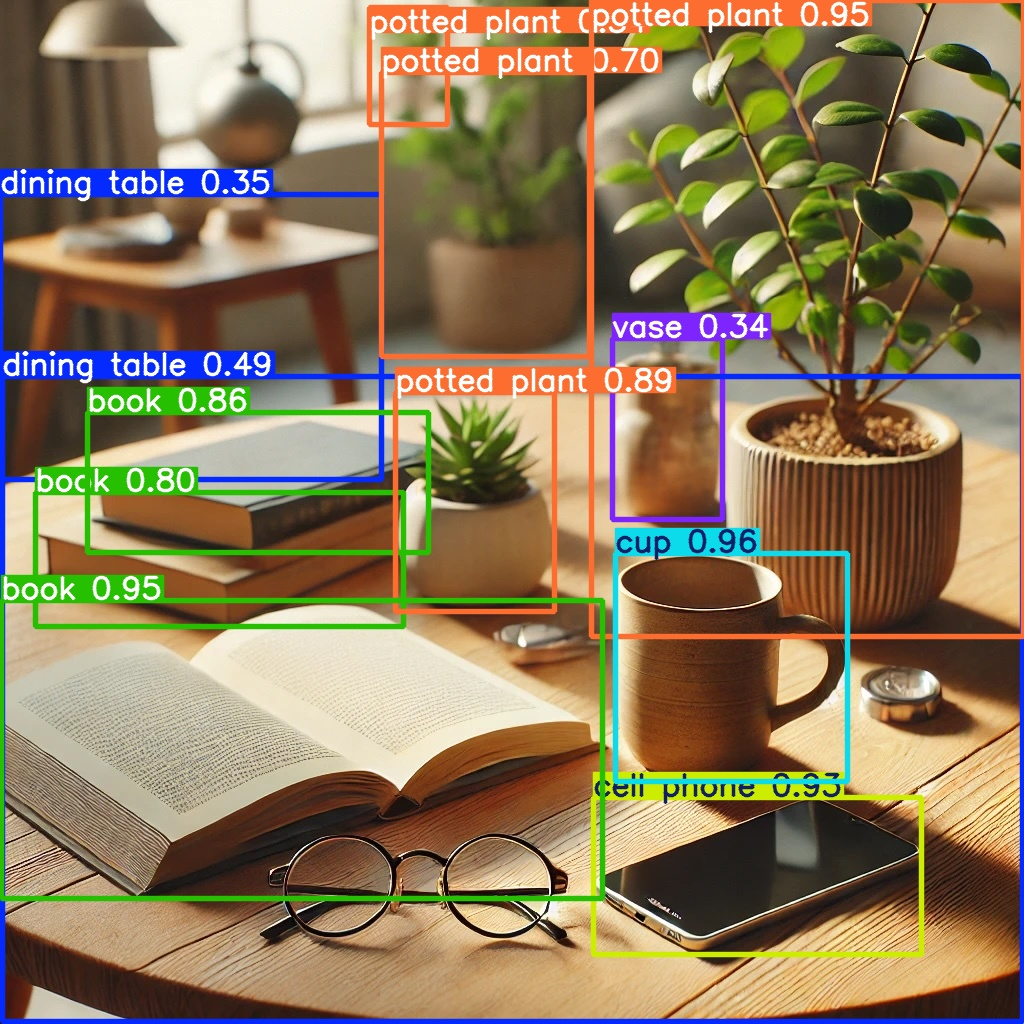

In [3]:
!apt-get update && apt-get install -y libgl1
!pip install ultralytics --quiet


from ultralytics import YOLO
from PIL import Image

# Modell laden
model = YOLO("yolov8m.pt")  # du kannst auch yolov8n.pt verwenden

# Inferenz durchführen
results = model("https://raw.githubusercontent.com/zhaw-iwi/MultimodalInteraction_ObjDet/main/images/table_scene.jpeg")

# Bild mit Bounding Boxes speichern
results[0].save(filename="yolo_output.jpg")

# Bild anzeigen
Image.open("yolo_output.jpg")





Für Aufgabe 3

In [10]:
!pip install python-dotenv
import openai
import os
import base64
from dotenv import load_dotenv

load_dotenv()
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))



def encode_image(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

image_path = "street_scene (1).jpg"

base64_image = encode_image(image_path)

response = client.chat.completions.create(

    model="gpt-4-vision-preview",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                        "This image shows an accident scene. "
                        "Please analyze it and return a JSON list of all people in the image "
                        "with their positions (left/middle/right), status (conscious/unconscious), "
                        "and any visible injuries or danger signs. "
                        "Use this format: "
                        "[{\"position\": \"left\", \"status\": \"unconscious\", \"injury\": \"head wound\"}, ...]"
                    )
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    max_tokens=750
)

gpt_output = response.choices[0].message.content
print(gpt_output)


OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable